# Задание № 6

Обучить сиамскую сеть для верификации лиц на датасете LFW.
Библиотеки: [Python, Tensorflow]

Датасет LabeledFacesintheWild [LFW](http://vis-www.cs.umass.edu/lfw/#explore) содержит 13233 изображений
5749 персон. Данный набор формировался специально для проведения тестирования алгоритмов распознавания лиц. LFW содержит специальный тестовый список из 6000 пар изображений, разделѐнный на 10 частей, по 300 совпадающих пар и по 3

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import imageio
from skimage.transform import resize
%matplotlib inline

## Загрузка LFW

> Загрузка датасета с помощью [Tensor Flow Datasets](https://www.tensorflow.org/datasets/catalog/lfw)

In [2]:
# tfds.disable_progress_bar()
(label_train, img_train), (label_test, img_test) = tfds.load( 
    'lfw',
    split=['train[:90%]', 'train[90%:]'],
    batch_size=-1,
    as_supervised=True,
    shuffle_files=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/lfw/0.1.0.incompleteT4UBX3/lfw-train.tfrecord*...:   0%|          | 0/1323…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
print(f'Image size: {img_train.shape[1:]}')
print(f'Train exemples: {img_train.shape[0]}')
print(f'Test examples: {img_test.shape[0]}')

Image size: (250, 250, 3)
Train exemples: 11910
Test examples: 1323


In [4]:
# вычислим количество классов
classes = np.unique(np.concatenate((label_train, label_test)))
print(f'Number unique classes: {len(classes)}')

Number unique classes: 5749


In [16]:
uniq, counts = np.unique(label_test, return_counts=True)

In [17]:
print(np.asarray((uniq, counts)).T)

[[b'Aaron_Peirsol' 1]
 [b'Aaron_Sorkin' 1]
 [b'Abbas_Kiarostami' 1]
 ...
 [b'Zhang_Ziyi' 1]
 [b'Zinedine_Zidane' 2]
 [b'Zoran_Djindjic' 1]]


## Визуализация

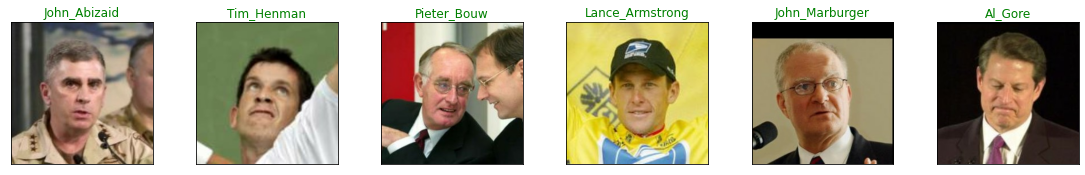

In [ ]:
some_samples = [img_train[x] for x in range(6)]
some_labels = [label_train[x] for x in range(6)]

fig = plt.figure(figsize=(26, 12))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j + 1)
    ax.imshow(some_samples[j])
    ax.set_title(some_labels[j].numpy().decode('ascii'), c='green')
    plt.xticks([]), plt.yticks([])
plt.show()

## Процедура подготовки данных

In [ ]:
INP_SIZE = img_train.shape[1]
NUM_EPOCHS = 3
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000


def resize_images(img, label):
    img = tf.cast(img, tf.float32) / 255. 
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label


# общая обработка тренировочной выборки
img_train = tf.data.Dataset.from_tensor_slices((img_train, label_train))
img_train = img_train.map(resize_images, num_parallel_calls=AUTOTUNE)
img_train = img_train.repeat(NUM_EPOCHS)
img_train = img_train.batch(BATCH_SIZE)

## Создание модели CNN

> Выходной вектор 128 мерный

In [ ]:
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),  # функция активации не нужна
])

## Расчет функции потерь contrastive_loss

In [ ]:
MARGIN = 20.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]  # часть эмбеддингов 32
    embs2 = embs[bs//2:, :]  # 2-я часть эмбеддингов 32
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)  # вектор размера 32
    d =  tf.sqrt(d2)  # вектор размера 32
    z = tf.cast(labels1 == labels2, tf.float32)  # вектор размера 32
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)  # одно число для целого батча

LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [ ]:
%%time

for iteration, (images, labels) in enumerate(img_train):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 389.45709228515625
[200] Loss: 0.0
[400] Loss: 1.113650918006897
[600] Loss: 5.6884918212890625
[800] Loss: 3.38468337059021
[1000] Loss: 0.40230897068977356
CPU times: user 1min 12s, sys: 15.7 s, total: 1min 27s
Wall time: 5min 11s


## Сравнение эмбеддингов

In [ ]:
# функция расчета евклидова расстояния
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [ ]:
# посмотрим, какие классы встречаются несколько раз
labels_for_compare = [i for i in classes if len(np.where(label_test == i)[0]) > 1]

In [ ]:
labels_for_compare[:3]

[b'Adrien_Brody', b'Alejandro_Toledo', b'Alex_Sink']

In [ ]:
# выберем один класс
test_pos = np.where(label_test == b'Alejandro_Toledo')[0]
test_pos

array([ 383,  568, 1146])

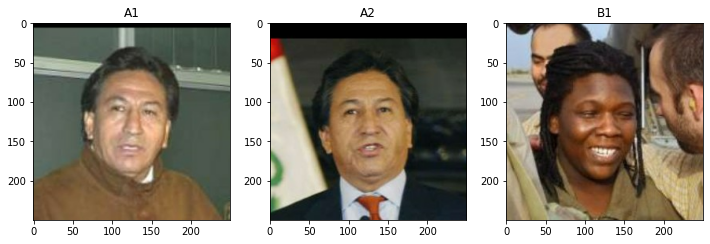

In [ ]:
# визуализируем изображения одного класса и разных из тестовой выборки

img_a1 = img_test[568]
img_a2 = img_test[1146]
img_b1 = img_test[100]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax.set_title('A1')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax.set_title('A2')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
ax.set_title('B1')
plt.show()

In [ ]:
# рассчитаем эмбеддинги и посмотрим на итоговые расстояния между изображениями
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  4710.9179572563135
A2 <-> B1:  8117.924118886552
A1 <-> B1:  5695.53825375618


### Вывод

Расстояния показывают, что модель довольно плохо уловила принципы разделения классов.

In [ ]:
# посмотрим на эмбеддинги 100 тестовых экземпляров
test_embs = model(img_test[:100])

## Визуализация чистых данных с помощью снижения размерности TNSE

In [ ]:
test_x_flat = img_test.numpy().reshape(-1, 250*250)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:100])  # отобразить в 2-хмерное пространство
labels_for_viz = label_test[:100].numpy()

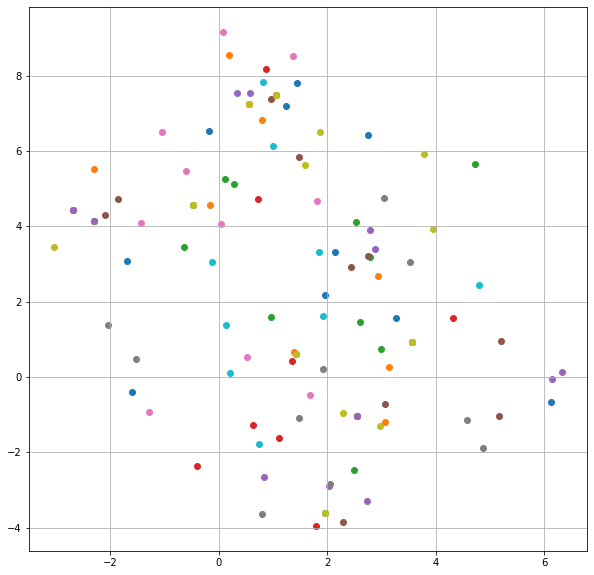

In [ ]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in targets:
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    # plt.legend(labels, loc='best')
    plt.grid(True)

draw_embeddings(test_x_2D, labels_for_viz, labels_for_viz)

## Визуализация эмбеддингов данных с помощью снижения размерности TNSE

In [ ]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
labels_for_viz = label_test[:100].numpy()

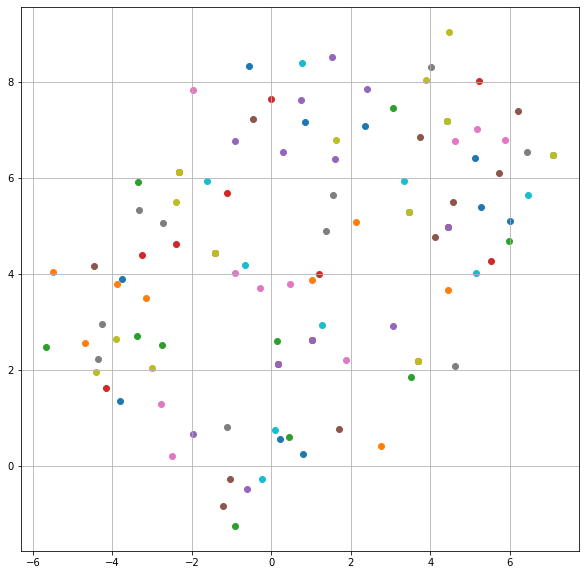

In [ ]:
draw_embeddings(test_embs_2D, labels_for_viz, labels_for_viz)

### Вывод

Графики подтверждают, что модель плохо уловила закономерности верификации лиц. Есть некоторое упорядочивание, но оно слабое. Вероятно, классов слишком много, а изображений слишком мало для статистического просчета.

## Обучение в режиме One-Shot Learning

In [ ]:
# загрузим фотографии
!wget https://s0.rbk.ru/v6_top_pics/media/img/8/13/756635050581138.jpg > alla_1.jpg
!wget https://resizer.mail.ru/p/6a9ef3ed-3969-50c5-b336-3d79241af24e/AAACUEwUwCfstHNwgLcapPo8-WDaILypCRvHOJByGdfuYayi2vynU_UxJbAtaQFMV-a8ptn1LF6mCGRRB2vexAGUGu8.jpg > alla_2.jpg
!wget https://www.kino-teatr.ru/acter/album/3175/40023.jpg > kristina.jpg

In [ ]:
# преобразуем изображения
def load_and_prepare_image(fpath):
    
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32) / 255.
    img = resize(img, (250, 250))
    return img

img_a1 = load_and_prepare_image('/content/756635050581138.jpg')
img_a2 = load_and_prepare_image('/content/AAACUEwUwCfstHNwgLcapPo8-WDaILypCRvHOJByGdfuYayi2vynU_UxJbAtaQFMV-a8ptn1LF6mCGRRB2vexAGUGu8.jpg')
img_b1 = load_and_prepare_image('/content/40023.jpg')

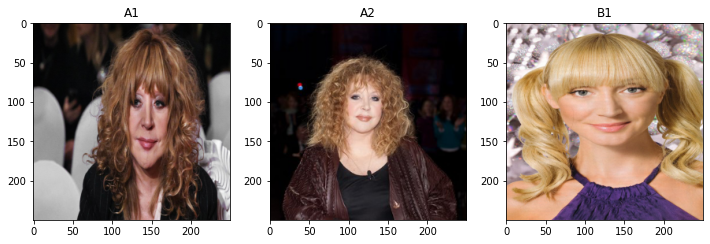

In [ ]:
# визуализируем изображения
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax.set_title('A1')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax.set_title('A2')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
ax.set_title('B1')
plt.show()

In [ ]:
# рассчитаем эмбеддинги и посмотрим на итоговые расстояния между изображениями
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  30.98843463382246
A2 <-> B1:  71.2130695134766
A1 <-> B1:  48.67300861440687


In [ ]:
# попробуем вырезать только лица
def load_and_prepare_image(fpath):
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32) / 255.
    # img = resize(img, (250, 250))
    return img

img_a1 = load_and_prepare_image('/content/756635050581138.jpg')[:600, 400:1000, :]
img_a2 = load_and_prepare_image('/content/AAACUEwUwCfstHNwgLcapPo8-WDaILypCRvHOJByGdfuYayi2vynU_UxJbAtaQFMV-a8ptn1LF6mCGRRB2vexAGUGu8.jpg')[50:300, 50:300, :]
img_b1 = load_and_prepare_image('/content/40023.jpg')[50:400, :, :]

img_a1 = resize(img_a1, (250, 250))
img_a2 = resize(img_a2, (250, 250))
img_b1 = resize(img_b1, (250, 250))

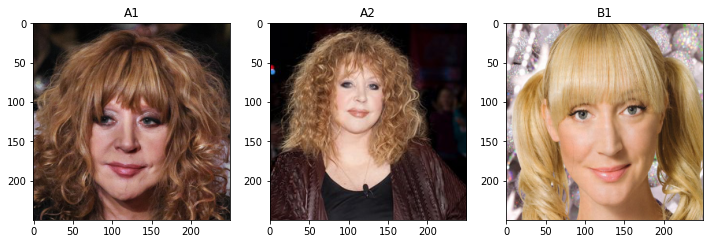

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax.set_title('A1')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax.set_title('A2')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
ax.set_title('B1')
plt.show()

In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  14.526438845674097
A2 <-> B1:  52.99095220530577
A1 <-> B1:  49.84840789364541


### Вывод

На новых данных модель уже лучше верифицировала похожие картинки, особенно в укрупненном варианте, где в кадре только лицо.